In [33]:
import pandas as pd

# Path to your Excel file
file_path = "DS.xlsx"

# Select columns by their names (list)
df = pd.read_excel(file_path)

udf = df[(df['facecount'] == 1) & (df['error'] == 0)]
udf=udf.drop(columns=['facecount', 'error'])
print(udf.columns)
print(udf)

Index(['fl', 'fr', 'rl', 'peakscf', 'peakscl', 'peakscr', 'maxif', 'maxil',
       'maxir', 'avgif', 'avgil', 'avgir', 'commonpeaksc', 'fake'],
      dtype='object')
            fl        fr        rl  peakscf  peakscl  peakscr     maxif  \
0    -0.042439 -0.076128  0.032870    126.0    107.0    101.0  0.000616   
1     0.003989  0.016873  0.189464     79.0     63.0     66.0  0.000426   
2     0.001951 -0.022430  0.238053     87.0     59.0     70.0  0.000323   
3     0.139257 -0.075425 -0.059161    130.0    101.0    100.0  0.001518   
4    -0.022830  0.030943  0.087365     93.0     70.0     63.0  0.000790   
...        ...       ...       ...      ...      ...      ...       ...   
1198 -0.033766 -0.045588  0.245791    120.0     91.0     87.0  0.000256   
1199  0.111370 -0.008250  0.029951    106.0    109.0     91.0  0.000363   
1200 -0.016104  0.049779  0.134011    115.0     95.0    115.0  0.000766   
1201  0.054624 -0.046698  0.247080    112.0     90.0    108.0  0.000262   
1202  0.0

# Decision Tree Classifier

Accuracy: 0.6387665198237885
Precision: 0.6586990102408605
Recall: 0.6387665198237885
F1 Score: 0.647083108614411
Confusion Matrix:
[[ 30  35]
 [ 47 115]]
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.46      0.42        65
           1       0.77      0.71      0.74       162

    accuracy                           0.64       227
   macro avg       0.58      0.59      0.58       227
weighted avg       0.66      0.64      0.65       227



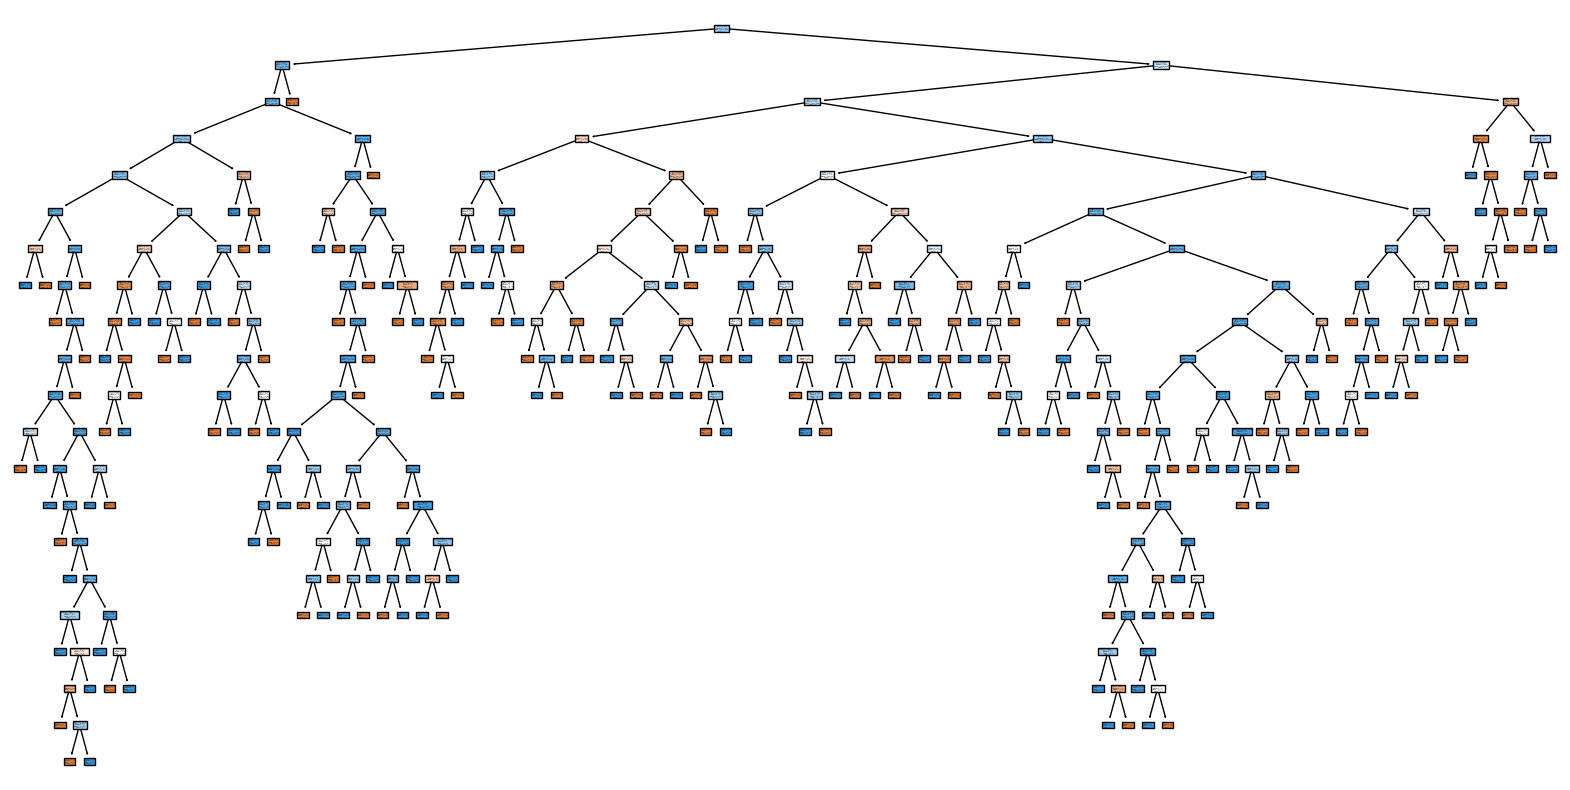

In [34]:
# Step 1: Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn import tree
import matplotlib.pyplot as plt

# Step 3: Splitting the Dataset
# Features
X = udf.drop(columns=['fake'])
# Target
y = udf['fake']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Training the Model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 5: Evaluating the Model
# Predicting on the test set
y_pred = clf.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculating precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision}')

# Calculating recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall}')

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# Generating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Generating classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# Visualizing the Decision Tree
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=X.columns, class_names=['0', '1'], filled=True)
plt.show()


# Random Forest

Accuracy: 0.73568281938326
Precision: 0.709303397754281
Recall: 0.73568281938326
F1 Score: 0.7044084178243887
Confusion Matrix:
[[ 19  46]
 [ 14 148]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.29      0.39        65
           1       0.76      0.91      0.83       162

    accuracy                           0.74       227
   macro avg       0.67      0.60      0.61       227
weighted avg       0.71      0.74      0.70       227



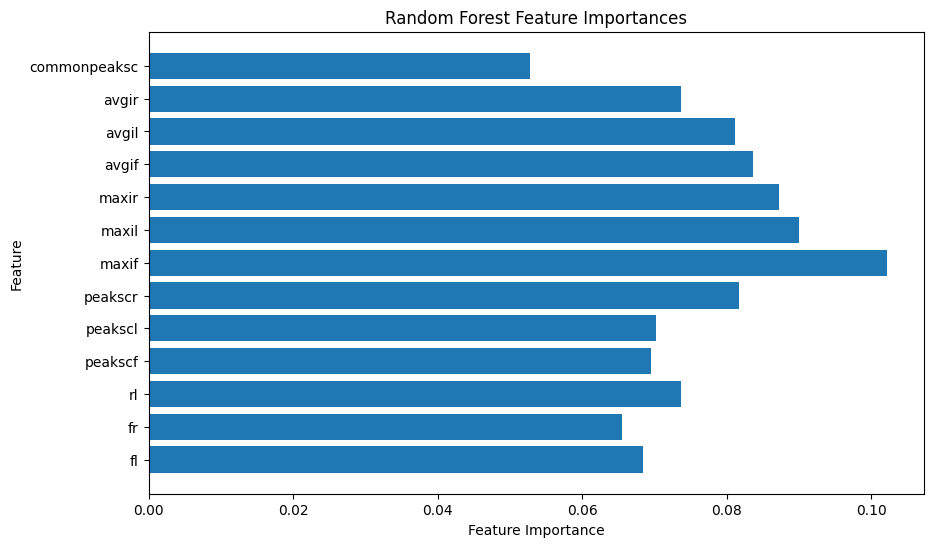

In [35]:
# Step 1: Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Step 2: Loading the Dataset
# Assuming the data is in a DataFrame named 'udf'
# Adjust this part according to your data loading method
X = udf.drop(columns=['fake'])  # Features
y = udf['fake']  # Target

# Step 3: Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Training the Random Forest Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Initialize RandomForestClassifier with 100 trees
clf.fit(X_train, y_train)

# Step 5: Evaluating the Model
# Predicting on the test set
y_pred = clf.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculating precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision}')

# Calculating recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall}')

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# Generating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Generating classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# Note: Random Forests do not provide a single tree visualization like Decision Trees

# Optionally, you can visualize feature importances if needed
feature_importances = clf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


# RF with Hyperparameter Tunining(Grid Search)

In [36]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize RandomForestClassifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found
print(f'Best parameters: {grid_search.best_params_}')

# Get the best model
best_clf = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.748898678414097
Precision: 0.7322902425439262
Recall: 0.748898678414097
F1 Score: 0.705163684492809


C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\dpava\OneDrive\Documents\Gi

# SVM

Accuracy: 0.7136563876651982
Precision: 0.5093054396553397
Recall: 0.7136563876651982
F1 Score: 0.5944078910116304
Confusion Matrix:
[[  0  65]
 [  0 162]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        65
           1       0.71      1.00      0.83       162

    accuracy                           0.71       227
   macro avg       0.36      0.50      0.42       227
weighted avg       0.51      0.71      0.59       227



C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

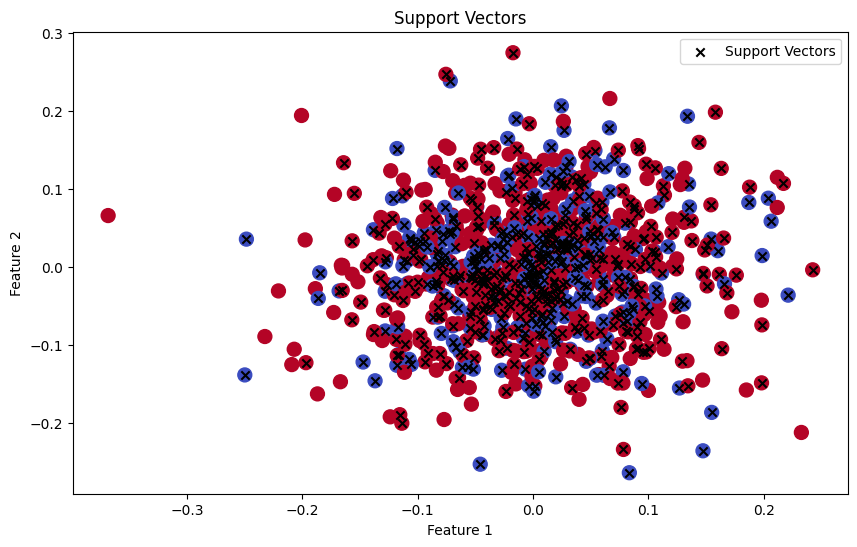

In [37]:
# Step 1: Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import Support Vector Classifier (SVC)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Step 2: Loading the Dataset
# Assuming the data is in a DataFrame named 'udf'
# Adjust this part according to your data loading method
X = udf.drop(columns=['fake'])  # Features
y = udf['fake']  # Target

# Step 3: Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Training the SVM Model
clf = SVC(kernel='rbf', random_state=42)  # Initialize Support Vector Classifier (SVC) with RBF kernel
clf.fit(X_train, y_train)

# Step 5: Evaluating the Model
# Predicting on the test set
y_pred = clf.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculating precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision}')

# Calculating recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall}')

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# Generating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Generating classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# Note: SVMs do not provide direct feature importances or decision tree visualization

# Optionally, you can visualize support vectors if needed
# Uncomment below lines if you want to visualize support vectors
plt.figure(figsize=(10, 6))
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap='coolwarm', s=100)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], color='k', marker='x', label='Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Support Vectors')
plt.show()


# GBM

[LightGBM] [Info] Number of positive: 599, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2595
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.661148 -> initscore=0.668414
[LightGBM] [Info] Start training from score 0.668414
Accuracy: 0.73568281938326
Precision: 0.7158886145670287
Recall: 0.73568281938326
F1 Score: 0.7193376237531549
Confusion Matrix:
[[ 25  40]
 [ 20 142]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        65
           1       0.78      0.88      0.83       162

    accuracy                           0.74       227
   macro avg       0.67      0.63      0.64       227
weighted avg       0.72      0.74      0.72       227



<Figure size 1000x600 with 0 Axes>

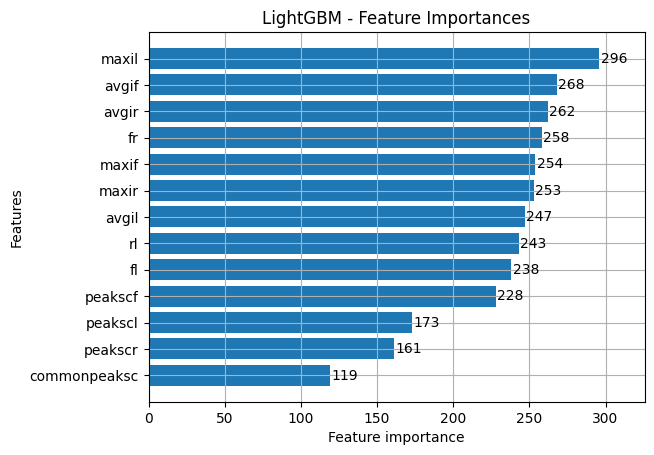

In [38]:
# Step 1: Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import lightgbm as lgb  # Import LightGBM
import matplotlib.pyplot as plt

# Step 2: Loading the Dataset
# Assuming the data is in a DataFrame named 'udf'
# Adjust this part according to your data loading method
X = udf.drop(columns=['fake'])  # Features
y = udf['fake']  # Target

# Step 3: Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Training the GBM Model
clf = lgb.LGBMClassifier(random_state=42)  # Initialize LightGBM classifier
clf.fit(X_train, y_train)

# Step 5: Evaluating the Model
# Predicting on the test set
y_pred = clf.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculating precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision}')

# Calculating recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall}')

# Calculating F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 Score: {f1}')

# Generating confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Generating classification report
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

# Visualizing feature importances
plt.figure(figsize=(10, 6))
lgb.plot_importance(clf, height=0.8)
plt.title("LightGBM - Feature Importances")
plt.show()

# ALL MODELS

Decision Tree Metrics:
Accuracy: 0.6387665198237885
Precision: 0.6586990102408605
Recall: 0.6387665198237885
F1 Score: 0.647083108614411
------------------------------------
Random Forest Metrics:
Accuracy: 0.73568281938326
Precision: 0.709303397754281
Recall: 0.73568281938326
F1 Score: 0.7044084178243887
------------------------------------
SVM Metrics:
Accuracy: 0.7136563876651982
Precision: 0.5093054396553397
Recall: 0.7136563876651982
F1 Score: 0.5944078910116304
------------------------------------
[LightGBM] [Info] Number of positive: 599, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2595
[LightGBM] [Info] Number of data points in the train set: 906, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.661148 -> initscore=0.668414
[LightGBM] [Info] Start training from score 0.668414
Light

C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


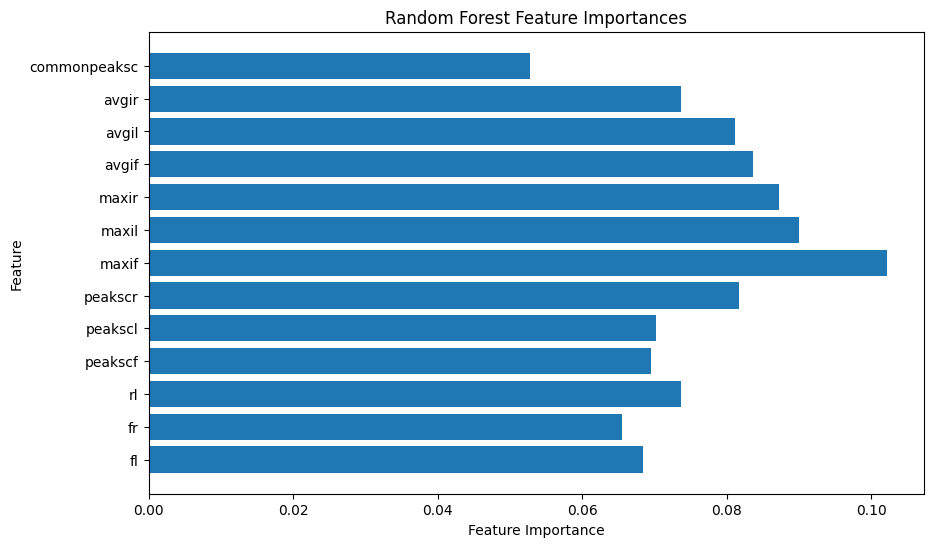

<Figure size 1000x600 with 0 Axes>

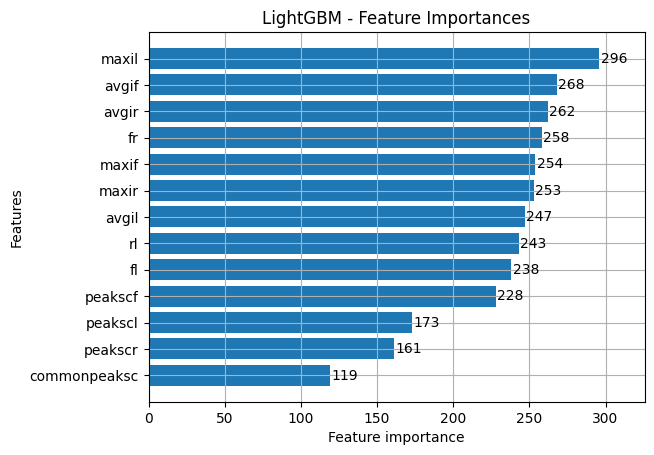

In [39]:
# Step 1: Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame named 'udf'
# Adjust this part according to your data loading method
X = udf.drop(columns=['fake'])  # Features
y = udf['fake']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models initialization
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

# Dictionary to store results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

# Training, evaluating each model and storing results
for model_name, model in models.items():
    # Training
    model.fit(X_train, y_train)
    
    # Predicting on the test set
    y_pred = model.predict(X_test)
    
    # Metrics calculation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Storing results
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    
    # Printing metrics
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("------------------------------------")

# Creating a DataFrame for results
results_df = pd.DataFrame(results)

# Displaying results table
print("\nResults Summary:")
print(results_df)

# Optionally, you can visualize additional plots if needed (e.g., confusion matrix, feature importance)

# Example: Confusion Matrix for Decision Tree
clf_dt = models['Decision Tree']
y_pred_dt = clf_dt.predict(X_test)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("\nConfusion Matrix (Decision Tree):")
print(conf_matrix_dt)

# Example: Feature Importance for Random Forest
clf_rf = models['Random Forest']
feature_importances = clf_rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

# Example: Feature Importance for LightGBM
clf_gbm = models['LightGBM']
plt.figure(figsize=(10, 6))
lgb.plot_importance(clf_gbm, height=0.8)
plt.title("LightGBM - Feature Importances")
plt.show()


Decision Tree Metrics:
Accuracy: 0.6387665198237885
Precision: 0.6586990102408605
Recall: 0.6387665198237885
F1 Score: 0.647083108614411
------------------------------------
Random Forest Metrics:
Accuracy: 0.73568281938326
Precision: 0.709303397754281
Recall: 0.73568281938326
F1 Score: 0.7044084178243887
------------------------------------
SVM Metrics:
Accuracy: 0.7136563876651982
Precision: 0.5093054396553397
Recall: 0.7136563876651982
F1 Score: 0.5944078910116304
------------------------------------


C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


GBM Metrics:
Accuracy: 0.7444933920704846
Precision: 0.7216591180894737
Recall: 0.7444933920704846
F1 Score: 0.7142614705635756
------------------------------------

Results Summary:
           Model  Accuracy  Precision    Recall  F1 Score
0  Decision Tree  0.638767   0.658699  0.638767  0.647083
1  Random Forest  0.735683   0.709303  0.735683  0.704408
2            SVM  0.713656   0.509305  0.713656  0.594408
3            GBM  0.744493   0.721659  0.744493  0.714261

Confusion Matrix (Decision Tree):
[[ 30  35]
 [ 47 115]]


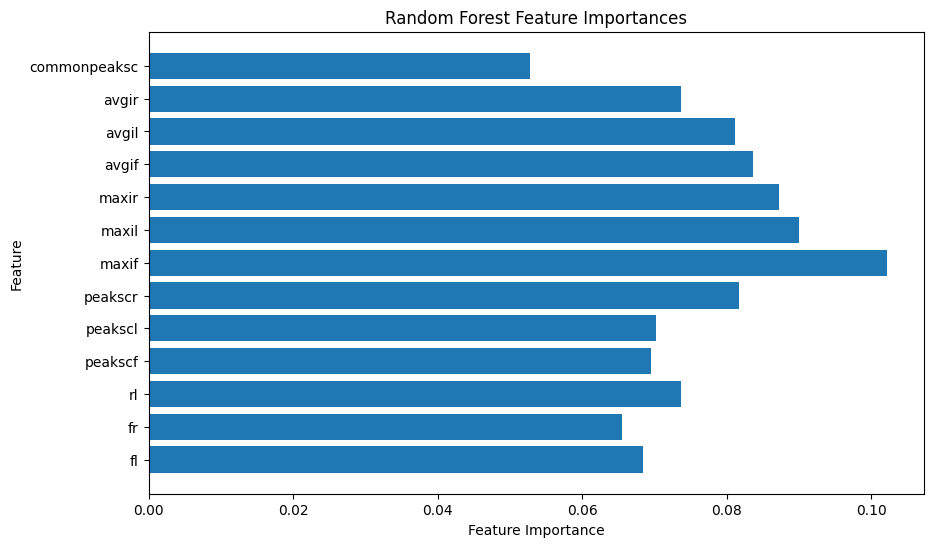

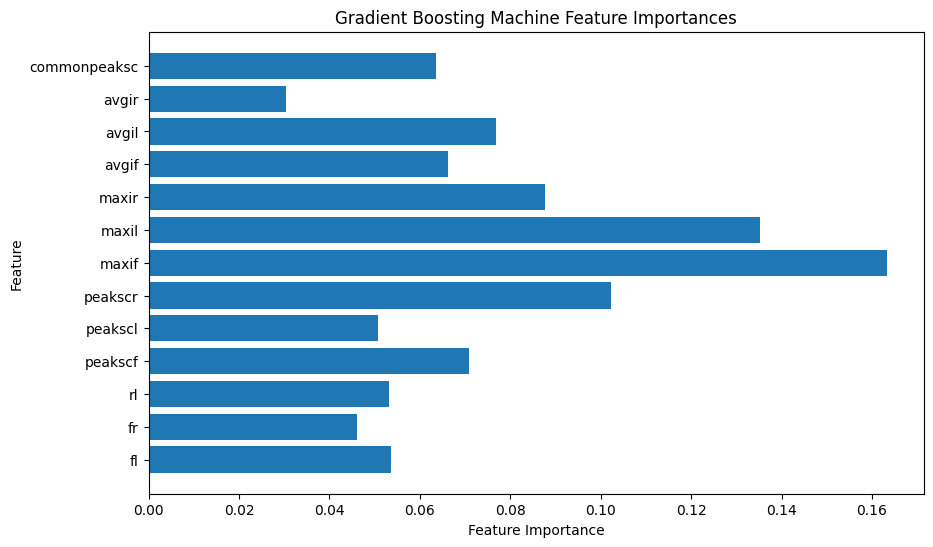

In [40]:
# Step 1: Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame named 'udf'
# Adjust this part according to your data loading method
X = udf.drop(columns=['fake'])  # Features
y = udf['fake']  # Target

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models initialization
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "GBM": GradientBoostingClassifier(random_state=42)
}

# Dictionary to store results
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

# Training, evaluating each model and storing results
for model_name, model in models.items():
    # Training
    model.fit(X_train, y_train)
    
    # Predicting on the test set
    y_pred = model.predict(X_test)
    
    # Metrics calculation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Storing results
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)
    
    # Printing metrics
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print("------------------------------------")

# Creating a DataFrame for results
results_df = pd.DataFrame(results)

# Displaying results table
print("\nResults Summary:")
print(results_df)

# Optionally, you can visualize additional plots if needed (e.g., confusion matrix, feature importance)

# Example: Confusion Matrix for Decision Tree
clf_dt = models['Decision Tree']
y_pred_dt = clf_dt.predict(X_test)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("\nConfusion Matrix (Decision Tree):")
print(conf_matrix_dt)

# Example: Feature Importance for Random Forest
clf_rf = models['Random Forest']
feature_importances = clf_rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

# Example: Feature Importance for GBM
clf_gbm = models['GBM']
feature_importances_gbm = clf_gbm.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances_gbm)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Gradient Boosting Machine Feature Importances')
plt.show()


# AdaBoost

In [43]:
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Separate features and target
X = udf.drop(columns=['fake'])  # Features
y = udf['fake']  # Target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features if needed (example using StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize AdaBoost classifier with GridSearchCV for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

grid_search = GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1)
   
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(f'Best parameters found: {best_params}')

# Fit AdaBoost classifier with best parameters
adaboost_clf = best_estimator
adaboost_clf.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = adaboost_clf.predict(X_test_scaled)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))

print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\ensemble\_weight_boostin

Best parameters found: {'learning_rate': 0.1, 'n_estimators': 100}


C:\Users\dpava\OneDrive\Documents\GitHub\HeartRate_Prediction\projectv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.17      0.26        65
           1       0.74      0.94      0.83       162

    accuracy                           0.72       227
   macro avg       0.64      0.56      0.54       227
weighted avg       0.68      0.72      0.67       227

Confusion Matrix:
[[ 11  54]
 [  9 153]]
